In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.img_exploration_env import ImageExplorationEnv, RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor, visualize_reconstruction

import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor


2025-02-06 16:05:19.924 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Farama interface for custom ImageEnv

In [3]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"

tiny_imagenet_transform = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=tiny_imagenet_transform
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=tiny_imagenet_transform
)

tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, shuffle=True)
tiny_imagenet_val_loader = DataLoader(tiny_imagenet_val_dataset, batch_size=1, shuffle=False)

In [5]:
image, _ = tiny_imagenet_train_dataset[15080]

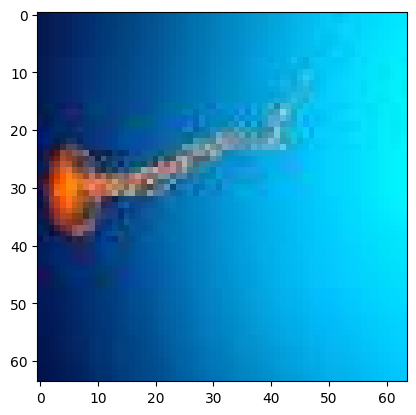

In [6]:
plt.imshow(image)

In [53]:
custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
reward_function = RewardFunction(custom_model)

inputs = image_processor(images=image, return_tensors="pt")
env = ImageExplorationEnv(inputs.pixel_values, reward_function, config=custom_model.config)

cum_rewards = []
cum_reward = 0
terminated = False

observation, info = env.reset()

# Random walk loop
while not terminated:
    action = env.action_space.sample()

    next_observation, reward, terminated, truncated, info = env.step(action)
    cum_reward += reward.detach().numpy()

    if env.step_count % env.interval_reward_assignment == 0:
        print(f"Cum reward={cum_reward}")
        cum_rewards.append(cum_reward)
        cum_reward = 0

    observation = next_observation

env.close()

Cum reward=0.5036220550537109
Cum reward=0.48515570163726807
Cum reward=0.4431302547454834
Cum reward=0.4917728304862976
Cum reward=0.5506471395492554
Cum reward=0.6696271300315857
Cum reward=0.6815284490585327
Cum reward=0.7734928131103516
Cum reward=0.8279849886894226
Cum reward=0.8451575636863708
Cum reward=0.8450852632522583
Cum reward=0.8065133094787598
Cum reward=0.8031207919120789
Cum reward=0.816434383392334
Cum reward=0.7943107485771179
Cum reward=0.7885711193084717
Cum reward=0.786442220211029
Cum reward=0.7893734574317932
Cum reward=0.7869331240653992
Cum reward=0.7845341563224792
Terminated


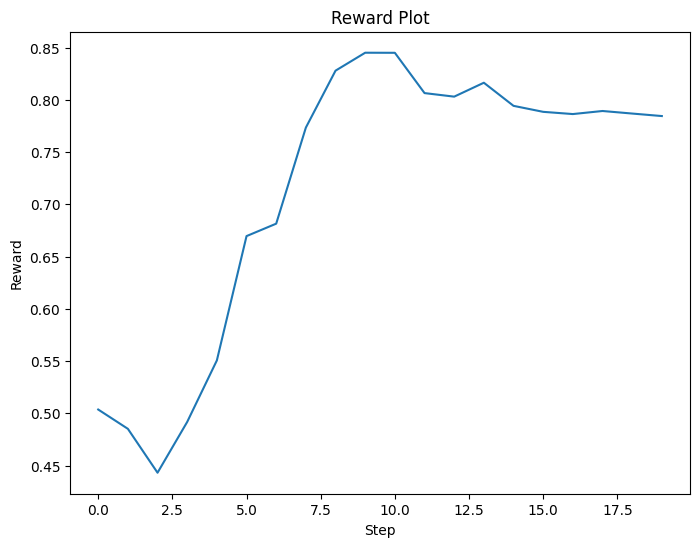

In [54]:
# Plot the rewards
plt.figure(figsize=(8, 6))  # Set the figure size to 8x6 inches
plt.plot(cum_rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Reward Plot")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


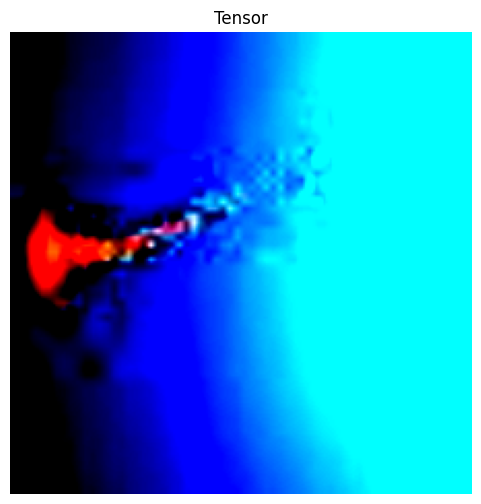

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.095515..2.5568948].


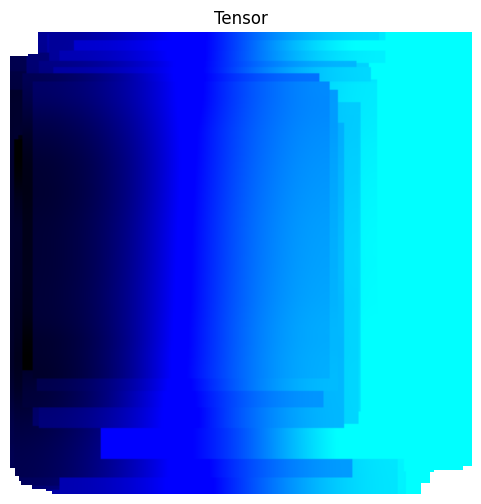

In [55]:
visualize_tensor(env.img)
visualize_tensor(env.sampled_img)

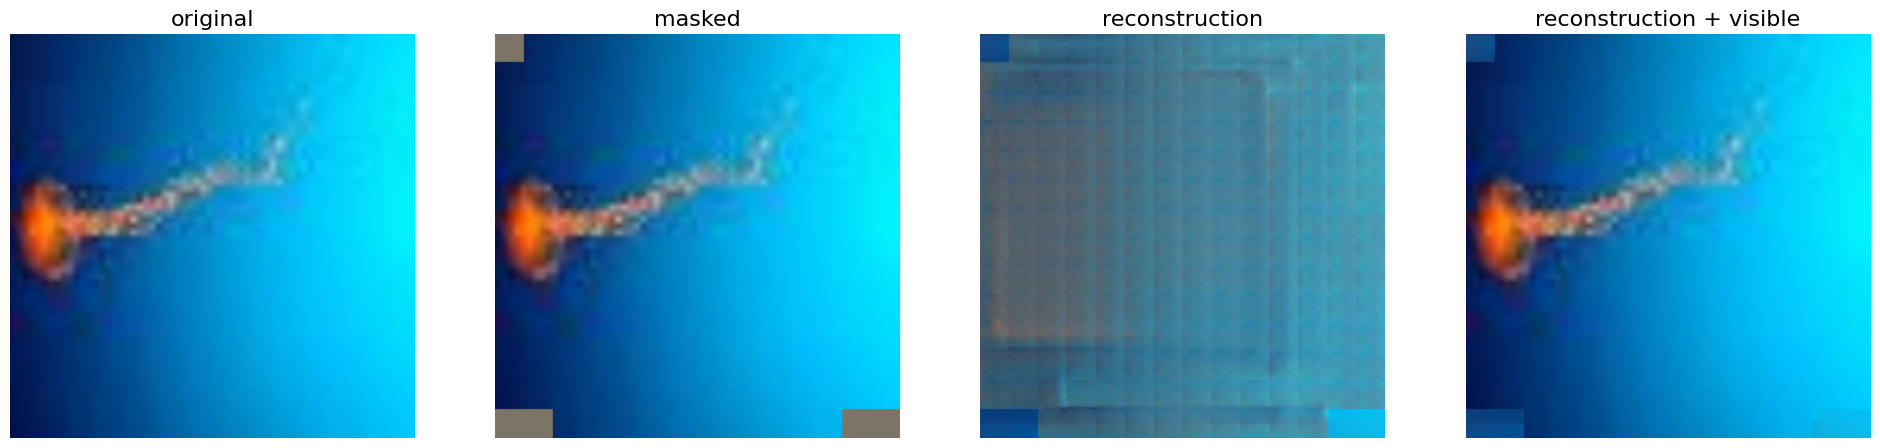

In [56]:
visualize_reconstruction(env.img, env.sampled_img, custom_model)